# Antenna Clustering Optimization - Comparison

This notebook compares the original Monte Carlo algorithm with the optimized version.

**Implemented optimizations:**
1. Greedy initialization (iterations 1-10)
2. Local search refinement
3. Adaptive probability sampling (iterations 51+)
4. NumPy vectorization in kernel computation

## 1. Setup and Import

In [1]:
# Install dependencies if on Colab
import sys
if 'google.colab' in sys.modules:
    print("Running on Colab - installing dependencies...")
    %pip install numpy scipy matplotlib cupy-cuda12x -q
    print("Done! CuPy installed for GPU acceleration.")

In [2]:
import numpy as np
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# OPT: Try to import CuPy for GPU acceleration
try:
    import cupy as cp
    GPU_AVAILABLE = cp.cuda.is_available()
    if GPU_AVAILABLE:
        print("[OK] GPU available - CuPy active")
        xp = cp  # Use CuPy for array operations
    else:
        print("[WARN] CuPy installed but GPU not available - using CPU")
        xp = np
        GPU_AVAILABLE = False
except ImportError:
    print("[INFO] CuPy not installed - using CPU (install with: pip install cupy-cuda12x)")
    xp = np
    GPU_AVAILABLE = False

print("Imports completed!")

[INFO] CuPy not installed - using CPU (install with: pip install cupy-cuda12x)
Imports completed!


## 2. Configuration Classes Definition

In [3]:
@dataclass
class LatticeConfig:
    """Lattice array configuration"""
    Nz: int  # Number of rows
    Ny: int  # Number of columns
    dist_z: float  # antenna distance on z axis [times lambda]
    dist_y: float  # antenna distance on y axis [times lambda]
    lattice_type: int = 1  # 1=Rectangular

@dataclass
class SystemConfig:
    """System parameters"""
    freq: float  # [Hz]
    lambda_: float = field(init=False)
    beta: float = field(init=False)
    azi0: float = 0.0
    ele0: float = 0.0
    dele: float = 0.5
    dazi: float = 0.5

    def __post_init__(self):
        self.lambda_ = 3e8 / self.freq
        self.beta = 2 * np.pi / self.lambda_

@dataclass
class MaskConfig:
    """SLL mask parameters"""
    elem: float = 30.0
    azim: float = 60.0
    SLL_level: float = 20.0
    SLLin: float = 15.0

@dataclass
class ElementPatternConfig:
    """Element pattern configuration"""
    P: int = 1
    Gel: float = 5.0
    load_file: int = 0

@dataclass
class SimulationConfig:
    """Simulation parameters"""
    Niter: int = 1000
    Cost_thr: int = 1000

@dataclass
class ClusterConfig:
    """Cluster configuration for free-form clustering.

    Parameters:
    - max_cluster_size: maximum number of elements in a cluster (1 to N).
    - min_cluster_size: minimum number of elements in a cluster (default 1).
    """
    max_cluster_size: int = 3
    min_cluster_size: int = 1

print("Configuration classes defined!")

Configuration classes defined!


## 3. AntennaArray Class (with kernel optimizations)

In [4]:
class AntennaArray:
    """Class for antenna arrays with clustering"""

    def __init__(self, lattice: LatticeConfig, system: SystemConfig, 
                 mask: MaskConfig, eef_config: Optional[ElementPatternConfig] = None):
        self.lattice = lattice
        self.system = system
        self.mask = mask
        self.eef_config = eef_config or ElementPatternConfig()
        self.Nel = lattice.Nz * lattice.Ny

        self._compute_lattice_vectors()
        self._generate_lattice()
        self._generate_polar_coordinates()
        self._generate_element_pattern()
        self._generate_mask()

    def _compute_lattice_vectors(self):
        lambda_ = self.system.lambda_
        dz = self.lattice.dist_z * lambda_
        dy = self.lattice.dist_y * lambda_
        self.x1 = np.array([dy, 0.0])
        self.x2 = np.array([0.0, dz])

    def _generate_lattice(self):
        Nz = self.lattice.Nz
        Ny = self.lattice.Ny

        if Nz % 2 == 1:
            M = np.arange(-(Nz - 1) / 2, (Nz - 1) / 2 + 1)
        else:
            M = np.arange(-Nz / 2 + 1, Nz / 2 + 1)

        if Ny % 2 == 1:
            N = np.arange(-(Ny - 1) / 2, (Ny - 1) / 2 + 1)
        else:
            N = np.arange(-Ny / 2 + 1, Ny / 2 + 1)

        self.NN, self.MM = np.meshgrid(N, M)
        dz = self.x2[1]
        dy = self.x1[0]
        DELTA = max(self.x2[0], self.x1[1])

        self.Y = self.NN * dy
        self.Z = self.MM * dz
        self.Y[1::2, :] = self.Y[1::2, :] + DELTA

        self.Dz = np.max(self.Z) - np.min(self.Z)
        self.Dy = np.max(self.Y) - np.min(self.Y)
        self.Dy_total = self.Dy + self.x1[0]
        self.Dz_total = self.Dz + self.x2[1]
        self.ArrayMask = np.ones_like(self.Y)

    def _generate_polar_coordinates(self):
        beta = self.system.beta
        lambda_ = self.system.lambda_

        self.ele = np.arange(-90, 90 + self.system.dele, self.system.dele)
        self.azi = np.arange(-90, 90 + self.system.dazi, self.system.dazi)
        self.AZI, self.ELE = np.meshgrid(self.azi, self.ele)

        self.WWae = beta * np.cos(np.deg2rad(90 - self.ELE))
        self.Vvae = beta * np.sin(np.deg2rad(90 - self.ELE)) * np.sin(np.deg2rad(self.AZI))

        chi = 2
        self.Nw = int(np.floor(chi * 4 * self.Dz_total / lambda_))
        self.Nv = int(np.floor(chi * 4 * self.Dy_total / lambda_))

        ww = np.linspace(0, beta, self.Nw + 1)
        self.ww = np.concatenate([-np.flip(ww[1:]), ww])
        vv = np.linspace(0, beta, self.Nv + 1)
        self.vv = np.concatenate([-np.flip(vv[1:]), vv])

        self.WW, self.VV = np.meshgrid(self.ww, self.vv)

        WW_clipped = np.clip(self.WW / beta, -1, 1)
        self.ELEi = 90 - np.rad2deg(np.arccos(WW_clipped))

        denom = beta * np.sin(np.deg2rad(90 - self.ELEi))
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio = np.clip(self.VV / denom, -1, 1)
            self.AZIi = np.real(np.rad2deg(np.arcsin(ratio)))

        self.AZIi[self.Nv, :] = 0
        self.AZIi[self.Nv, 0] = 90
        self.AZIi[self.Nv, -1] = 90

    def _generate_element_pattern(self):
        P = self.eef_config.P
        Gel = self.eef_config.Gel

        if P == 0:
            self.Fel = np.ones_like(self.ELE)
        else:
            self.Fel = (np.cos(np.deg2rad(self.ELE * 0.9)) * np.cos(np.deg2rad(self.AZI * 0.9))) ** P

        if P == 0:
            self.Fel_VW = np.ones_like(self.ELEi)
        else:
            self.Fel_VW = (np.cos(np.deg2rad(self.ELEi * 0.9)) * np.cos(np.deg2rad(self.AZIi * 0.9))) ** P

        self.RPE = 20 * np.log10(np.abs(self.Fel) + 1e-10)
        self.RPE_ele_max = np.max(self.RPE) + Gel
        self.G_boresight = self.RPE_ele_max + 10 * np.log10(self.Nel)

    def _generate_mask(self):
        ele0 = self.system.ele0
        azi0 = self.system.azi0
        elem = self.mask.elem
        azim = self.mask.azim
        SLL_level = self.mask.SLL_level
        SLLin = self.mask.SLLin

        ele_cond = np.abs(self.ELE - ele0) <= elem
        azi_cond = np.abs(self.AZI - azi0) <= azim

        self.in_fov_mask = ele_cond & azi_cond
        self.out_fov_mask = ~self.in_fov_mask

        self.Mask_EA = np.full_like(self.ELE, self.G_boresight - SLL_level, dtype=float)
        self.Mask_EA[self.in_fov_mask] = self.G_boresight - SLLin

    def index_to_position_cluster(self, Cluster: List[np.ndarray], 
                                   ElementExc: Optional[np.ndarray] = None):
        if ElementExc is None:
            ElementExc = np.ones((self.lattice.Nz, self.lattice.Ny))

        Ntrans = len(Cluster)
        max_Lsub = max(c.shape[0] for c in Cluster)

        Yc = np.full((max_Lsub, Ntrans), np.nan)
        Zc = np.full((max_Lsub, Ntrans), np.nan)
        Ac = np.full((max_Lsub, Ntrans), np.nan)

        min_NN = int(np.min(self.NN))
        min_MM = int(np.min(self.MM))

        for kk, cluster in enumerate(Cluster):
            for l1 in range(cluster.shape[0]):
                Iy = int(cluster[l1, 0] - min_NN)
                Iz = int(cluster[l1, 1] - min_MM)
                Yc[l1, kk] = self.Y[Iz, Iy]
                Zc[l1, kk] = self.Z[Iz, Iy]
                Ac[l1, kk] = ElementExc[Iz, Iy]

        return Yc, Zc, Ac

    def coefficient_evaluation(self, Zc_m: np.ndarray, Yc_m: np.ndarray, Lsub: np.ndarray):
        beta = self.system.beta
        ele0 = self.system.ele0
        azi0 = self.system.azi0

        v0 = beta * np.sin(np.deg2rad(90 - ele0)) * np.sin(np.deg2rad(azi0))
        w0 = beta * np.cos(np.deg2rad(90 - ele0))
        Phase_m = np.exp(-1j * (w0 * Zc_m + v0 * Yc_m))
        Amplit_m = 1.0 / Lsub
        c0 = Amplit_m * Phase_m
        return c0

    def kernel1_rpe(self, Lsub: np.ndarray, Ac: np.ndarray, 
                    Yc: np.ndarray, Zc: np.ndarray, c0: np.ndarray):
        Ntrans = len(Lsub)

        # OPT: Cache flattened arrays
        if not hasattr(self, '_VV_flat'):
            self._VV_flat = self.VV.flatten()
            self._WW_flat = self.WW.flatten()
            self._Fel_VW_flat = self.Fel_VW.flatten()

        VV_flat = self._VV_flat
        WW_flat = self._WW_flat
        Fel_VW_flat = self._Fel_VW_flat
        Npoints = len(VV_flat)

        # OPT: Vectorized kernel computation
        all_Y = []
        all_Z = []
        all_Ac = []  # FIX: collect element excitation weights
        cluster_indices = []

        for kk in range(Ntrans):
            Lsub_k = int(Lsub[kk])
            for jj in range(Lsub_k):
                if not np.isnan(Yc[jj, kk]) and not np.isnan(Zc[jj, kk]):
                    all_Y.append(Yc[jj, kk])
                    all_Z.append(Zc[jj, kk])
                    all_Ac.append(Ac[jj, kk] if not np.isnan(Ac[jj, kk]) else 1.0)
                    cluster_indices.append(kk)

        all_Y_np = np.array(all_Y)
        all_Z_np = np.array(all_Z)
        all_Ac_np = np.array(all_Ac)  # FIX: element excitation array
        cluster_indices_np = np.array(cluster_indices)

        # OPT: GPU acceleration - transfer to GPU if available
        if GPU_AVAILABLE:
            all_Y_gpu = xp.asarray(all_Y_np)
            all_Z_gpu = xp.asarray(all_Z_np)
            all_Ac_gpu = xp.asarray(all_Ac_np)  # FIX: transfer Ac to GPU
            VV_flat_gpu = xp.asarray(VV_flat)
            WW_flat_gpu = xp.asarray(WW_flat)
            Fel_VW_flat_gpu = xp.asarray(Fel_VW_flat)
            
            # Compute phases on GPU
            phases = xp.exp(1j * (xp.outer(VV_flat_gpu, all_Y_gpu) + xp.outer(WW_flat_gpu, all_Z_gpu)))
            phases = phases * Fel_VW_flat_gpu[:, xp.newaxis]
            phases = phases * all_Ac_gpu[xp.newaxis, :]  # FIX: apply element excitation
            
            # Transfer back to CPU for add.at (not available in CuPy)
            phases_np = cp.asnumpy(phases)
        else:
            # CPU computation
            phases_np = np.exp(1j * (np.outer(VV_flat, all_Y_np) + np.outer(WW_flat, all_Z_np)))
            phases_np = phases_np * Fel_VW_flat[:, np.newaxis]
            phases_np = phases_np * all_Ac_np[np.newaxis, :]  # FIX: apply Ac

        # OPT: Sum contributions using np.add.at
        KerFF_sub = np.zeros((Npoints, Ntrans), dtype=complex)
        np.add.at(KerFF_sub.T, cluster_indices_np, phases_np.T)

        FF = KerFF_sub @ c0.T
        FF_norm = FF / (np.max(np.abs(FF)) + 1e-10)
        FF_norm_2D = FF_norm.reshape(self.VV.shape)
        FF_norm_dB = 20 * np.log10(np.abs(FF_norm_2D) + 1e-10)

        # OPT: Cache interpolation setup - use LinearNDInterpolator for much faster repeated interpolation
        if not hasattr(self, '_interp_points'):
            self._interp_points = np.column_stack([WW_flat, VV_flat])
            self._interp_xi = np.column_stack([self.WWae.flatten(), self.Vvae.flatten()])
            # OPT: Pre-compute Delaunay triangulation (expensive, but done only once)
            self._delaunay = Delaunay(self._interp_points)

        # OPT: Use cached triangulation for fast interpolation
        values = FF_norm_dB.flatten()
        interpolator = LinearNDInterpolator(self._delaunay, values, fill_value=-100)
        FF_I_dB_flat = interpolator(self._interp_xi)
        FF_I_dB = FF_I_dB_flat.reshape(self.WWae.shape)

        Nel_active = np.sum(Lsub)
        FF_I_dB = FF_I_dB + self.RPE_ele_max + 10 * np.log10(Nel_active)

        return FF_norm_dB, FF_I_dB, KerFF_sub, np.abs(FF_norm_2D) ** 2

    def compute_cost_function(self, FF_I_dB: np.ndarray) -> int:
        Constr = FF_I_dB - self.Mask_EA
        Cm = np.sum(Constr > 0)
        return int(Cm)

    def compute_sll(self, FF_I_dB: np.ndarray, G_boresight: float = None):
        """FIX: Trova vero side lobe escludendo regione main lobe."""
        if G_boresight is None:
            G_boresight = np.max(FF_I_dB)

        # SLL out-of-FoV
        sll_out_values = FF_I_dB[self.out_fov_mask]
        sll_out = (np.max(sll_out_values) - G_boresight) if len(sll_out_values) > 0 else -100

        # FIX: SLL in-FoV - escludi regione main lobe
        main_idx = np.unravel_index(np.argmax(FF_I_dB), FF_I_dB.shape)
        ele_excl = int(10 / self.system.dele) if hasattr(self, 'system') else 10
        azi_excl = int(10 / self.system.dazi) if hasattr(self, 'system') else 10

        main_lobe_mask = np.zeros_like(FF_I_dB, dtype=bool)
        ele_start = max(0, main_idx[0] - ele_excl)
        ele_end = min(FF_I_dB.shape[0], main_idx[0] + ele_excl + 1)
        azi_start = max(0, main_idx[1] - azi_excl)
        azi_end = min(FF_I_dB.shape[1], main_idx[1] + azi_excl + 1)
        main_lobe_mask[ele_start:ele_end, azi_start:azi_end] = True

        sidelobe_mask = self.in_fov_mask & ~main_lobe_mask
        sll_in = np.max(FF_I_dB[sidelobe_mask]) - G_boresight if np.any(sidelobe_mask) else -100

        return sll_in, sll_out

    def evaluate_clustering(self, Cluster: List[np.ndarray], 
                            ElementExc: Optional[np.ndarray] = None) -> Dict:
        if ElementExc is None:
            ElementExc = np.ones((self.lattice.Nz, self.lattice.Ny))

        Yc, Zc, Ac = self.index_to_position_cluster(Cluster, ElementExc)
        Ntrans = len(Cluster)

        Lsub = np.array([c.shape[0] for c in Cluster])
        Zc_m = np.array([np.nanmean(Zc[:Lsub[k], k]) for k in range(Ntrans)])
        Yc_m = np.array([np.nanmean(Yc[:Lsub[k], k]) for k in range(Ntrans)])

        c0 = self.coefficient_evaluation(Zc_m, Yc_m, Lsub)
        FF_norm_dB, FF_I_dB, KerFF_sub, FF_norm = self.kernel1_rpe(Lsub, Ac, Yc, Zc, c0)

        Cm = self.compute_cost_function(FF_I_dB)
        
        # Calcola G_boresight prima di compute_sll
        G_boresight = self.RPE_ele_max + 10 * np.log10(np.sum(Lsub))
        sll_in, sll_out = self.compute_sll(FF_I_dB, G_boresight)

        max_idx = np.unravel_index(np.argmax(FF_I_dB), FF_I_dB.shape)
        theta_max = self.ele[max_idx[0]]
        phi_max = self.azi[max_idx[1]]

        Iele = np.argmin(np.abs(self.ele - self.system.ele0))
        Iazi = np.argmin(np.abs(self.azi - self.system.azi0))

        SL_maxpointing = G_boresight - FF_I_dB[max_idx]
        SL_theta_phi = G_boresight - FF_I_dB[Iele, Iazi]

        return {
            "Yc": Yc, "Zc": Zc, "Ac": Ac, "Yc_m": Yc_m, "Zc_m": Zc_m,
            "Lsub": Lsub, "Ntrans": Ntrans, "c0": c0,
            "FF_norm_dB": FF_norm_dB, "FF_I_dB": FF_I_dB, "KerFF_sub": KerFF_sub,
            "Cm": Cm, "sll_in": sll_in, "sll_out": sll_out,
            "theta_max": theta_max, "phi_max": phi_max,
            "SL_maxpointing": SL_maxpointing, "SL_theta_phi": SL_theta_phi,
            "G_boresight": G_boresight,
        }

print("AntennaArray class defined!")

AntennaArray class defined!


## 4. Subarray Generation Class

In [5]:
class FreeFormSubarraySetGeneration:
    """Generate ALL possible connected clusters (FREE FORM shapes).

    This class generates every possible connected cluster of elements
    from size min_size to max_size. Connectivity is 4-way (up/down/left/right).

    For a 16x16 array with max_size=4, this generates ~6000 unique clusters.
    """

    def __init__(self, lattice: LatticeConfig, NN: np.ndarray, MM: np.ndarray,
                 max_size: int = 4, min_size: int = 1):
        self.lattice = lattice
        self.NN = NN
        self.MM = MM
        self.max_size = max_size
        self.min_size = min_size

        # Get array bounds
        self.min_N = int(np.min(NN))
        self.max_N = int(np.max(NN))
        self.min_M = int(np.min(MM))
        self.max_M = int(np.max(MM))

        # Generate all connected clusters
        self.S, self.Nsub = self._generate_all_connected()

    def _get_neighbors(self, pos):
        """Get 4-connected neighbors of a position (n, m)"""
        n, m = pos
        neighbors = []
        # Up, Down, Left, Right
        for dn, dm in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nn, nm = n + dn, m + dm
            if self.min_N <= nn <= self.max_N and self.min_M <= nm <= self.max_M:
                neighbors.append((nn, nm))
        return neighbors

    def _generate_all_connected(self):
        """Generate all connected clusters using iterative expansion"""
        all_clusters = set()  # Use set of frozensets for deduplication

        # All valid positions in the array
        all_positions = []
        for n in range(self.min_N, self.max_N + 1):
            for m in range(self.min_M, self.max_M + 1):
                all_positions.append((n, m))

        # Start with single elements
        current_level = [frozenset([pos]) for pos in all_positions]

        # Add single-element clusters if min_size <= 1
        if self.min_size <= 1:
            all_clusters.update(current_level)

        # Iteratively expand to larger sizes
        for size in range(2, self.max_size + 1):
            next_level = set()

            for cluster in current_level:
                # Find all neighbors of the current cluster
                cluster_neighbors = set()
                for pos in cluster:
                    for neighbor in self._get_neighbors(pos):
                        if neighbor not in cluster:
                            cluster_neighbors.add(neighbor)

                # Try adding each neighbor
                for neighbor in cluster_neighbors:
                    new_cluster = frozenset(cluster | {neighbor})
                    if new_cluster not in next_level and new_cluster not in all_clusters:
                        next_level.add(new_cluster)

            # Add clusters of this size if >= min_size
            if size >= self.min_size:
                all_clusters.update(next_level)

            current_level = list(next_level)

        # Convert to list of numpy arrays (sorted for consistency)
        S = []
        for cluster_frozen in all_clusters:
            cluster_list = sorted(list(cluster_frozen))  # Sort for consistency
            cluster_array = np.array(cluster_list)
            S.append(cluster_array)

        # Sort clusters by size then by first element for reproducibility
        S.sort(key=lambda x: (x.shape[0], tuple(x[0])))

        return S, len(S)


print("FreeFormSubarraySetGeneration class defined!")

FreeFormSubarraySetGeneration class defined!


## 5. Optimizer Class (with all optimizations)

In [6]:
class IrregularClusteringMonteCarlo:
    """Clustering optimization with Monte Carlo approach.

    Uses 3-phase optimization:
    - Phase 1 (iter 1-10): Greedy initialization
    - Phase 2 (iter 11-50): Random sampling
    - Phase 3 (iter 51+): Adaptive sampling
    Plus local search refinement.
    """

    def __init__(self, array: AntennaArray, cluster_config: ClusterConfig,
                 sim_config: SimulationConfig):
        self.array = array
        self.cluster_config = cluster_config
        self.sim_config = sim_config

        # Generate all possible connected clusters (FREE FORM)
        print(f"[MC] Generating free-form clusters (size {cluster_config.min_cluster_size}-{cluster_config.max_cluster_size})...")
        gen = FreeFormSubarraySetGeneration(
            array.lattice, array.NN, array.MM,
            max_size=cluster_config.max_cluster_size,
            min_size=cluster_config.min_cluster_size
        )
        self.S_all = [gen.S]
        self.N_all = [gen.Nsub]
        self.L = [cluster.shape[0] for cluster in gen.S]
        print(f"[MC] Generated {gen.Nsub} free-form clusters")

        # Build flat list of all clusters for easy access
        self._all_clusters_flat = []
        for S in self.S_all:
            self._all_clusters_flat.extend(S)

        # Pre-compute cluster elements as sets (OPTIMIZATION)
        self._cluster_elements = [
            set(tuple(pos) for pos in cluster)
            for cluster in self._all_clusters_flat
        ]

        self.simulation = []
        self.all_Cm = []
        self.all_Ntrans = []

        # Adaptive probability tracking
        self.total_clusters = sum(self.N_all)
        self._cluster_scores = np.ones(self.total_clusters)
        self._selection_counts = np.ones(self.total_clusters)

    def _remove_overlaps(self, selected_rows: np.ndarray):
        """Remove overlapping clusters using pre-computed element sets."""
        indices = np.where(selected_rows == 1)[0]
        np.random.shuffle(indices)

        covered_elements = set()
        valid_rows = np.zeros_like(selected_rows)
        valid_clusters = []

        for idx in indices:
            cluster_elements = self._cluster_elements[idx]
            if not (cluster_elements & covered_elements):
                valid_rows[idx] = 1
                valid_clusters.append(self._all_clusters_flat[idx])
                covered_elements.update(cluster_elements)

        return valid_clusters, valid_rows

    def _select_random_clusters(self):
        """Random selection (50% probability) with overlap removal."""
        selected_rows = np.random.randint(0, 2, size=self.total_clusters)
        return self._remove_overlaps(selected_rows)

    def _select_adaptive_clusters(self):
        """Adaptive probability selection with overlap removal."""
        probs = self._cluster_scores / self._selection_counts
        probs = np.clip(probs, 0.1, 0.9)
        selected_rows = (np.random.random(self.total_clusters) < probs).astype(int)
        return self._remove_overlaps(selected_rows)

    def _update_adaptive_scores(self, selected_rows: np.ndarray, Cm: int):
        """Update adaptive scores based on solution quality."""
        normalized_cm = Cm / self.sim_config.Cost_thr
        reward = np.exp(-normalized_cm)
        indices = np.where(selected_rows == 1)[0]
        self._cluster_scores[indices] += reward
        self._selection_counts[indices] += 1

    def _greedy_initialization(self, max_clusters: int = None):
        """Greedy initialization - select non-overlapping clusters."""
        if max_clusters is None:
            max_clusters = self.total_clusters // 2

        covered_elements = set()
        selected_indices = []

        available_indices = list(range(self.total_clusters))
        np.random.shuffle(available_indices)

        for idx in available_indices:
            if len(selected_indices) >= max_clusters:
                break
            cluster_elements = self._cluster_elements[idx]
            if not (cluster_elements & covered_elements):
                selected_indices.append(idx)
                covered_elements.update(cluster_elements)

        selected_rows = np.zeros(self.total_clusters, dtype=int)
        selected_rows[selected_indices] = 1
        selected_clusters = [self._all_clusters_flat[i] for i in selected_indices]

        return selected_clusters, selected_rows

    def _rows_to_clusters(self, selected_rows: np.ndarray):
        """Convert selection array to cluster list."""
        return [self._all_clusters_flat[i] for i in np.where(selected_rows == 1)[0]]

    def _local_search(self, selected_rows: np.ndarray, current_Cm: int,
                      max_iterations: int = 10):
        """Local search - flip single bits and check for improvement."""
        best_rows = selected_rows.copy()
        best_Cm = current_Cm

        # Get currently covered elements
        covered = set()
        for idx in np.where(best_rows == 1)[0]:
            covered.update(self._cluster_elements[idx])

        for _ in range(max_iterations):
            improved = False
            indices_to_try = np.random.permutation(self.total_clusters)[:20]

            for idx in indices_to_try:
                candidate_rows = best_rows.copy()

                if candidate_rows[idx] == 1:
                    # Flip 1->0: remove cluster (always valid)
                    candidate_rows[idx] = 0
                else:
                    # Flip 0->1: add cluster (check overlap first)
                    cluster_elements = self._cluster_elements[idx]
                    if cluster_elements & covered:
                        continue  # Would overlap, skip

                    candidate_rows[idx] = 1

                clusters = self._rows_to_clusters(candidate_rows)
                if len(clusters) == 0:
                    continue

                result = self.array.evaluate_clustering(clusters)
                candidate_Cm = result["Cm"]

                if candidate_Cm < best_Cm:
                    best_rows = candidate_rows
                    best_Cm = candidate_Cm
                    # Update covered set
                    covered = set()
                    for i in np.where(best_rows == 1)[0]:
                        covered.update(self._cluster_elements[i])
                    improved = True
                    break

            if not improved:
                break

        return best_rows, best_Cm

    def run(self, verbose: bool = True) -> Dict:
        """Execute 3-phase optimization."""
        start_time = time.time()

        if verbose:
            print("=" * 60)
            print("MONTE CARLO CLUSTERING OPTIMIZATION")
            print(f"  Free-form clusters: size {self.cluster_config.min_cluster_size}-{self.cluster_config.max_cluster_size}")
            print(f"  3-Phase approach: Greedy -> Random -> Adaptive")
            print("=" * 60)
            print(f"Array: {self.array.lattice.Nz}x{self.array.lattice.Ny} = {self.array.Nel} elements")
            print(f"Available clusters: {self.total_clusters}")
            print(f"Iterations: {self.sim_config.Niter}")
            print("=" * 60)

        best_Cm_so_far = float("inf")

        for ij_cont in range(1, self.sim_config.Niter + 1):
            if verbose and ij_cont % 50 == 0:
                pct = (ij_cont / self.sim_config.Niter) * 100
                print(f"  [Progress: {ij_cont}/{self.sim_config.Niter} ({pct:.0f}%) | Best Cm: {best_Cm_so_far:.0f}]")

            # 3-Phase selection strategy
            if ij_cont <= 10:
                if verbose and ij_cont == 1:
                    print("  >> Phase 1: Greedy initialization (iter 1-10)")
                Cluster, selected_rows = self._greedy_initialization()
            elif ij_cont <= 50:
                if verbose and ij_cont == 11:
                    print("  >> Phase 2: Random sampling (iter 11-50)")
                Cluster, selected_rows = self._select_random_clusters()
            else:
                if verbose and ij_cont == 51:
                    print("  >> Phase 3: Adaptive sampling (iter 51+)")
                Cluster, selected_rows = self._select_adaptive_clusters()

            if len(Cluster) == 0:
                self.all_Cm.append(float("inf"))
                self.all_Ntrans.append(0)
                continue

            result = self.array.evaluate_clustering(Cluster)
            Cm = result["Cm"]
            Ntrans = result["Ntrans"]

            # Local search refinement (every 25 iterations if promising)
            if Cm < best_Cm_so_far * 0.8 and ij_cont % 25 == 0:
                old_Cm = Cm
                selected_rows, Cm = self._local_search(selected_rows, Cm, max_iterations=10)
                if Cm < old_Cm:
                    Cluster = self._rows_to_clusters(selected_rows)
                    if len(Cluster) > 0:
                        result = self.array.evaluate_clustering(Cluster)
                        Cm = result["Cm"]
                        Ntrans = result["Ntrans"]

            self._update_adaptive_scores(selected_rows, Cm)

            self.all_Cm.append(Cm)
            self.all_Ntrans.append(Ntrans)

            if Cm < best_Cm_so_far:
                best_Cm_so_far = Cm

            if Cm < self.sim_config.Cost_thr:
                solution = {
                    "selected_rows": selected_rows.copy(),
                    "Cm": Cm,
                    "Ntrans": Ntrans,
                    "sll_in": result["sll_in"],
                    "sll_out": result["sll_out"],
                    "iteration": ij_cont,
                }
                self.simulation.append(solution)

        elapsed_time = time.time() - start_time

        if verbose:
            print()
            print("=" * 60)
            print("RESULTS")
            print("=" * 60)
            print(f"Iterations: {self.sim_config.Niter}")
            print(f"Valid solutions: {len(self.simulation)}")
            print(f"Time: {elapsed_time:.2f} s")

            if self.simulation:
                best_sol = min(self.simulation, key=lambda x: x["Cm"])
                print(f"\nBEST SOLUTION:")
                print(f"  Cm: {best_sol['Cm']}")
                print(f"  Ntrans: {best_sol['Ntrans']}")
                print(f"  SLL out: {best_sol['sll_out']:.2f} dB")
                print(f"  SLL in: {best_sol['sll_in']:.2f} dB")

        return {
            "simulation": self.simulation,
            "all_Cm": self.all_Cm,
            "all_Ntrans": self.all_Ntrans,
            "elapsed_time": elapsed_time,
            "n_valid_solutions": len(self.simulation),
        }

print("IrregularClusteringMonteCarlo class defined!")

IrregularClusteringMonteCarlo class defined!


## 6. Configuration

In [7]:
# ============================================================
# SHARED CONFIGURATION - Comparable parameters for MC vs GA
# ============================================================

# Total evaluation budget (same for both algorithms)
EVAL_BUDGET = 500  # Number of clustering evaluations
SEED = 42          # Random seed for reproducibility

# Array configuration
lattice = LatticeConfig(Nz=16, Ny=16, dist_z=0.6, dist_y=0.53, lattice_type=1)
system = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef = ElementPatternConfig(P=1, Gel=5, load_file=0)
cluster_config = ClusterConfig(max_cluster_size=3, min_cluster_size=1)

# MC configuration: Niter = EVAL_BUDGET
sim_config = SimulationConfig(Niter=EVAL_BUDGET, Cost_thr=1000)

# GA configuration: population * generations ≈ EVAL_BUDGET
GA_POPULATION = 25
GA_ELITE = 3
GA_GENERATIONS = (EVAL_BUDGET - GA_POPULATION) // (GA_POPULATION - GA_ELITE)  # ≈ 21

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"  Array: {lattice.Nz}x{lattice.Ny} = {lattice.Nz * lattice.Ny} elements")
print(f"  Frequency: {system.freq/1e9:.1f} GHz")
print(f"  Cluster size: {cluster_config.min_cluster_size}-{cluster_config.max_cluster_size}")
print()
print(f"  EVALUATION BUDGET: {EVAL_BUDGET}")
print()
print(f"  MC: {EVAL_BUDGET} iterations")
print(f"  GA: {GA_POPULATION} pop x {GA_GENERATIONS} gen = {GA_POPULATION + GA_GENERATIONS * (GA_POPULATION - GA_ELITE)} evals")
print("=" * 60)

CONFIGURATION
  Array: 16x16 = 256 elements
  Frequency: 29.5 GHz
  Cluster size: 1-3

  EVALUATION BUDGET: 500

  MC: 500 iterations
  GA: 25 pop x 21 gen = 487 evals


## 7. Array Initialization

In [8]:
print("Initializing antenna array...")
array = AntennaArray(lattice, system, mask, eef)
print("Array initialized!")

Initializing antenna array...
Array initialized!


## 9. OPTIMIZED Test

In [9]:
print("="*70)
print("RUNNING MONTE CARLO OPTIMIZATION")
print("="*70)

np.random.seed(SEED)
optimizer = IrregularClusteringMonteCarlo(array, cluster_config, sim_config)
results = optimizer.run(verbose=True)

RUNNING MONTE CARLO OPTIMIZATION
[MC] Generating free-form clusters (size 1-3)...
[MC] Generated 2084 free-form clusters
MONTE CARLO CLUSTERING OPTIMIZATION
  Free-form clusters: size 1-3
  3-Phase approach: Greedy -> Random -> Adaptive
Array: 16x16 = 256 elements
Available clusters: 2084
Iterations: 500
  >> Phase 1: Greedy initialization (iter 1-10)
  >> Phase 2: Random sampling (iter 11-50)
  [Progress: 50/500 (10%) | Best Cm: 417]
  >> Phase 3: Adaptive sampling (iter 51+)
  [Progress: 100/500 (20%) | Best Cm: 417]
  [Progress: 150/500 (30%) | Best Cm: 405]
  [Progress: 200/500 (40%) | Best Cm: 405]
  [Progress: 250/500 (50%) | Best Cm: 405]
  [Progress: 300/500 (60%) | Best Cm: 405]
  [Progress: 350/500 (70%) | Best Cm: 405]
  [Progress: 400/500 (80%) | Best Cm: 403]
  [Progress: 450/500 (90%) | Best Cm: 403]
  [Progress: 500/500 (100%) | Best Cm: 403]

RESULTS
Iterations: 500
Valid solutions: 500
Time: 370.57 s

BEST SOLUTION:
  Cm: 403
  Ntrans: 121
  SLL out: -21.53 dB
  SLL in

## 10. Results Comparison

In [10]:
print("="*70)
print("RESULTS SUMMARY")
print("="*70)
print()

def get_best(results):
    if results["n_valid_solutions"] == 0:
        return None
    return min(results["simulation"], key=lambda x: x["Cm"])

best = get_best(results)

if best:
    print(f"Best Cost Function (Cm):        {best['Cm']}")
    print(f"Best Ntrans (clusters):         {best['Ntrans']}")
    print(f"Best SLL out FoV:               {best['sll_out']:.2f} dB")
    print(f"Best SLL in FoV:                {best['sll_in']:.2f} dB")
    print(f"Found at iteration:             {best['iteration']}")
    print()
    print(f"Hardware reduction:             {(1 - best['Ntrans']/array.Nel)*100:.1f}%")
    print(f"Total valid solutions:          {results['n_valid_solutions']}")
    print(f"Execution time:                 {results['elapsed_time']:.2f} s")
else:
    print("No valid solutions found.")

RESULTS SUMMARY

Best Cost Function (Cm):        403
Best Ntrans (clusters):         121
Best SLL out FoV:               -21.53 dB
Best SLL in FoV:                -14.73 dB
Found at iteration:             350

Hardware reduction:             52.7%
Total valid solutions:          500
Execution time:                 370.57 s


## 10.1 Save Results to JSON

In [11]:
import json

def numpy_to_python(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int8, np.int16, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: numpy_to_python(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [numpy_to_python(v) for v in obj]
    return obj

def extract_stats(results):
    """Extract statistics from results."""
    all_Cm = [r["Cm"] for r in results["simulation"]]
    all_Ntrans = [r["Ntrans"] for r in results["simulation"]]
    all_sll_out = [r["sll_out"] for r in results["simulation"]]
    all_sll_in = [r["sll_in"] for r in results["simulation"]]
    return {
        "all_Cm": all_Cm,
        "all_Ntrans": all_Ntrans,
        "all_sll_out": all_sll_out,
        "all_sll_in": all_sll_in,
    }

def prepare_best_for_json(best):
    """Prepare best solution for JSON - remove numpy arrays, keep only metrics."""
    if best is None:
        return None
    return {
        "Cm": int(best["Cm"]),
        "Ntrans": int(best["Ntrans"]),
        "sll_in": float(best["sll_in"]),
        "sll_out": float(best["sll_out"]),
        "iteration": int(best["iteration"]),
    }

# Save results
json_data = {
    "algorithm": "monte_carlo_3phase",
    "n_valid_solutions": results["n_valid_solutions"],
    "execution_time": results["elapsed_time"],
    "statistics": numpy_to_python(extract_stats(results)),
    "best_solution": prepare_best_for_json(get_best(results)),
}

with open("../results/mc_results.json", "w") as f:
    json.dump(json_data, f, indent=2)
print("[OK] Saved: ../results/mc_results.json")

[OK] Saved: ../results/mc_results.json


## 11. Visualization

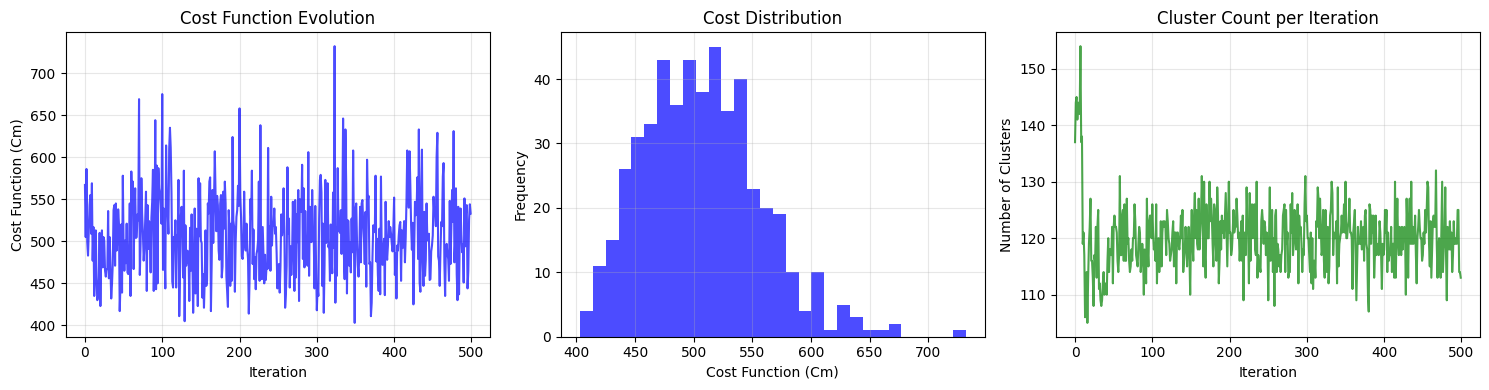

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cost function evolution
axes[0].plot(results['all_Cm'], 'b-', alpha=0.7)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost Function (Cm)')
axes[0].set_title('Cost Function Evolution')
axes[0].grid(True, alpha=0.3)

# Cost distribution (valid solutions < 5000)
cm_valid = [c for c in results['all_Cm'] if c != float('inf') and c < 5000]
if cm_valid:
    axes[1].hist(cm_valid, bins=30, alpha=0.7, color='blue')
    axes[1].set_xlabel('Cost Function (Cm)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Cost Distribution')
    axes[1].grid(True, alpha=0.3)

# Number of clusters
axes[2].plot(results['all_Ntrans'], 'g-', alpha=0.7)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Number of Clusters')
axes[2].set_title('Cluster Count per Iteration')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Genetic Algorithm with Real Physics

Now we run the genetic algorithm that uses the same physical calculations as Monte Carlo, but with true evolution (selection, crossover, mutation).

In [13]:
# ============================================================
# GENETIC ALGORITHM - Classes and Configuration
# ============================================================

@dataclass
class GAParams:
    """Genetic Algorithm Parameters"""
    population_size: int = 50
    max_generations: int = 100
    mutation_rate: float = 0.15
    crossover_rate: float = 0.8
    elite_size: int = 5
    random_seed: int = None


class GeneticAlgorithmOptimizer:
    """Genetic Algorithm for clustering optimization with overlap handling."""

    def __init__(self, array: AntennaArray, cluster_config: ClusterConfig,
                 ga_params: GAParams):
        self.array = array
        self.cluster_config = cluster_config
        self.params = ga_params

        # Generate all possible connected clusters (FREE FORM)
        print(f"[GA] Generating free-form clusters (size {cluster_config.min_cluster_size}-{cluster_config.max_cluster_size})...")
        gen = FreeFormSubarraySetGeneration(
            array.lattice, array.NN, array.MM,
            max_size=cluster_config.max_cluster_size,
            min_size=cluster_config.min_cluster_size
        )
        self.S_all = [gen.S]
        self.N_all = [gen.Nsub]
        print(f"[GA] Generated {gen.Nsub} free-form clusters")

        # Flatten for direct access
        self.all_subarrays = []
        for S_type in self.S_all:
            self.all_subarrays.extend(S_type)

        self.total_clusters = len(self.all_subarrays)

        # Pre-compute cluster elements as sets (OPTIMIZATION)
        self._cluster_elements = [
            set(tuple(pos) for pos in cluster)
            for cluster in self.all_subarrays
        ]

        self.population = []
        self.best_individual = None
        self.elapsed_time = 0

        self.history = {
            "best_fitness": [],
            "avg_fitness": [],
            "best_Cm": [],
            "best_sll_out": [],
            "best_sll_in": [],
            "best_n_clusters": [],
            "diversity": [],
        }

        print(f"GA initialized: {self.total_clusters} subarrays available")

    def _remove_overlaps(self, genes: np.ndarray) -> np.ndarray:
        """Remove overlapping clusters using pre-computed element sets."""
        indices = np.where(genes == 1)[0]
        np.random.shuffle(indices)

        covered_elements = set()
        valid_genes = np.zeros_like(genes)

        for idx in indices:
            cluster_elements = self._cluster_elements[idx]
            if not (cluster_elements & covered_elements):
                valid_genes[idx] = 1
                covered_elements.update(cluster_elements)

        return valid_genes

    def _create_random_genes(self) -> np.ndarray:
        """Create a random chromosome with no overlapping clusters."""
        genes = np.random.randint(0, 2, size=self.total_clusters)
        return self._remove_overlaps(genes)

    def _evaluate_genes(self, genes: np.ndarray) -> Dict:
        """Evaluate a chromosome using real physics. Assumes genes are already clean."""
        Cluster = [self.all_subarrays[i] for i in np.where(genes == 1)[0]]

        if len(Cluster) == 0:
            return {
                "valid": False, "fitness": -10000,
                "Cm": 99999, "sll_out": 0, "sll_in": 0, "n_clusters": 0
            }

        result = self.array.evaluate_clustering(Cluster)
        Cm = result["Cm"]
        n_clusters = result["Ntrans"]
        hardware_penalty = (n_clusters / self.array.Nel) * 50
        fitness = -Cm - hardware_penalty

        return {
            "valid": True,
            "fitness": fitness,
            "Cm": Cm,
            "sll_out": result["sll_out"],
            "sll_in": result["sll_in"],
            "n_clusters": n_clusters,
        }

    def initialize_population(self):
        """Create initial population with clean genes."""
        self.population = []
        for _ in range(self.params.population_size):
            genes = self._create_random_genes()  # Already removes overlaps
            result = self._evaluate_genes(genes)
            self.population.append({
                "genes": genes,
                "fitness": result["fitness"],
                "Cm": result["Cm"],
                "sll_out": result["sll_out"],
                "sll_in": result["sll_in"],
                "n_clusters": result["n_clusters"],
            })

    def _tournament_selection(self, tournament_size: int = 3) -> Dict:
        """Tournament selection."""
        contestants = np.random.choice(len(self.population), tournament_size, replace=False)
        winner_idx = max(contestants, key=lambda i: self.population[i]["fitness"])
        return self.population[winner_idx].copy()

    def _crossover(self, parent1: Dict, parent2: Dict) -> Tuple[np.ndarray, np.ndarray]:
        """Uniform crossover."""
        mask = np.random.randint(0, 2, size=self.total_clusters)
        child1_genes = np.where(mask, parent1["genes"], parent2["genes"])
        child2_genes = np.where(mask, parent2["genes"], parent1["genes"])
        return child1_genes, child2_genes

    def _mutate(self, genes: np.ndarray) -> np.ndarray:
        """Mutate genes."""
        genes = genes.copy()
        mask = np.random.random(self.total_clusters) < self.params.mutation_rate
        genes[mask] = 1 - genes[mask]
        return genes

    def _calculate_diversity(self) -> float:
        """Calculate genetic diversity."""
        genes_matrix = np.array([ind["genes"] for ind in self.population])
        return np.mean(np.std(genes_matrix, axis=0))

    def run(self, verbose=True):
        """Execute GA."""
        if verbose:
            print(f"\n{'='*60}")
            print(f"GENETIC ALGORITHM - ANTENNA CLUSTERING")
            print(f"  [FREE-FORM: clusters size {self.cluster_config.min_cluster_size}-{self.cluster_config.max_cluster_size}]")
            print(f"{'='*60}")
            print(f"Array: {self.array.lattice.Nz}x{self.array.lattice.Ny} elements")
            print(f"Available subarrays: {self.total_clusters}")
            print(f"Population: {self.params.population_size}")
            print(f"Generations: {self.params.max_generations}")
            print(f"{'='*60}\n")

        start_time = time.time()

        if verbose:
            print("Initializing population...")
        self.initialize_population()
        if verbose:
            print(f"   Completed in {time.time() - start_time:.1f}s\n")

        for generation in range(self.params.max_generations):
            gen_start = time.time()

            self.population.sort(key=lambda x: x["fitness"], reverse=True)
            best = self.population[0]
            avg_fitness = np.mean([ind["fitness"] for ind in self.population])
            diversity = self._calculate_diversity()

            self.history["best_fitness"].append(best["fitness"])
            self.history["avg_fitness"].append(avg_fitness)
            self.history["best_Cm"].append(best["Cm"])
            self.history["best_sll_out"].append(best["sll_out"])
            self.history["best_sll_in"].append(best["sll_in"])
            self.history["best_n_clusters"].append(best["n_clusters"])
            self.history["diversity"].append(diversity)

            gen_time = time.time() - gen_start

            if verbose:
                print(
                    f"Gen {generation+1:3d}/{self.params.max_generations} | "
                    f"Cm: {best['Cm']:4d} | "
                    f"SLL_out: {best['sll_out']:6.2f} dB | "
                    f"Clusters: {best['n_clusters']:3d} | "
                    f"Time: {gen_time:.1f}s"
                )

            # Early convergence check
            if generation > 5:
                recent = self.history["best_Cm"][-5:]
                if max(recent) - min(recent) < 5:
                    if verbose:
                        print(f"\n[OK] Convergence at generation {generation+1}")
                    break

            # Selection and reproduction
            elite = self.population[:self.params.elite_size]
            new_population = [e.copy() for e in elite]

            while len(new_population) < self.params.population_size:
                parent1 = self._tournament_selection()
                parent2 = self._tournament_selection()

                if np.random.random() < self.params.crossover_rate:
                    child1_genes, child2_genes = self._crossover(parent1, parent2)
                else:
                    child1_genes = parent1["genes"].copy()
                    child2_genes = parent2["genes"].copy()

                # Mutate and THEN remove overlaps (only place we call it)
                child1_genes = self._remove_overlaps(self._mutate(child1_genes))
                child2_genes = self._remove_overlaps(self._mutate(child2_genes))

                for genes in [child1_genes, child2_genes]:
                    if len(new_population) >= self.params.population_size:
                        break
                    result = self._evaluate_genes(genes)  # No overlap removal here
                    new_population.append({
                        "genes": genes,
                        "fitness": result["fitness"],
                        "Cm": result["Cm"],
                        "sll_out": result["sll_out"],
                        "sll_in": result["sll_in"],
                        "n_clusters": result["n_clusters"],
                    })

            self.population = new_population

        self.population.sort(key=lambda x: x["fitness"], reverse=True)
        self.best_individual = self.population[0]
        self.elapsed_time = time.time() - start_time

        if verbose:
            print(f"\n{'='*60}")
            print("GA COMPLETE")
            print(f"{'='*60}")
            print(f"Best Cm: {self.best_individual['Cm']}")
            print(f"SLL out: {self.best_individual['sll_out']:.2f} dB")
            print(f"SLL in: {self.best_individual['sll_in']:.2f} dB")
            print(f"Number of clusters: {self.best_individual['n_clusters']}")
            print(f"Total time: {self.elapsed_time:.1f}s")

        return self.best_individual

print("GAParams and GeneticAlgorithmOptimizer classes defined!")

GAParams and GeneticAlgorithmOptimizer classes defined!


In [14]:
# ============================================================
# GENETIC ALGORITHM EXECUTION (uses same BUDGET as MC)
# ============================================================

# GA Configuration using shared parameters
ga_params = GAParams(
    population_size=GA_POPULATION,
    max_generations=GA_GENERATIONS,
    mutation_rate=0.15,
    crossover_rate=0.8,
    elite_size=GA_ELITE,
)

# Create GA optimizer (uses same cluster configuration as MC)
ga_optimizer = GeneticAlgorithmOptimizer(array, cluster_config, ga_params)

# Run GA
best_ga = ga_optimizer.run(verbose=True)

print(f"\nGA completed in {ga_optimizer.elapsed_time:.1f}s")

[GA] Generating free-form clusters (size 1-3)...
[GA] Generated 2084 free-form clusters
GA initialized: 2084 subarrays available

GENETIC ALGORITHM - ANTENNA CLUSTERING
  [FREE-FORM: clusters size 1-3]
Array: 16x16 elements
Available subarrays: 2084
Population: 25
Generations: 21

Initializing population...
   Completed in 18.0s

Gen   1/21 | Cm:  407 | SLL_out: -20.15 dB | Clusters: 122 | Time: 0.0s
Gen   2/21 | Cm:  393 | SLL_out: -19.35 dB | Clusters: 104 | Time: 0.0s
Gen   3/21 | Cm:  377 | SLL_out: -19.14 dB | Clusters: 104 | Time: 0.0s
Gen   4/21 | Cm:  371 | SLL_out: -20.67 dB | Clusters:  88 | Time: 0.0s
Gen   5/21 | Cm:  371 | SLL_out: -20.67 dB | Clusters:  88 | Time: 0.0s
Gen   6/21 | Cm:  371 | SLL_out: -20.67 dB | Clusters:  88 | Time: 0.0s
Gen   7/21 | Cm:  371 | SLL_out: -20.67 dB | Clusters:  88 | Time: 0.0s
Gen   8/21 | Cm:  371 | SLL_out: -20.67 dB | Clusters:  88 | Time: 0.0s

[OK] Convergence at generation 8

GA COMPLETE
Best Cm: 371
SLL out: -20.67 dB
SLL in: -14.6

## 13. MC vs GA Comparison Plot

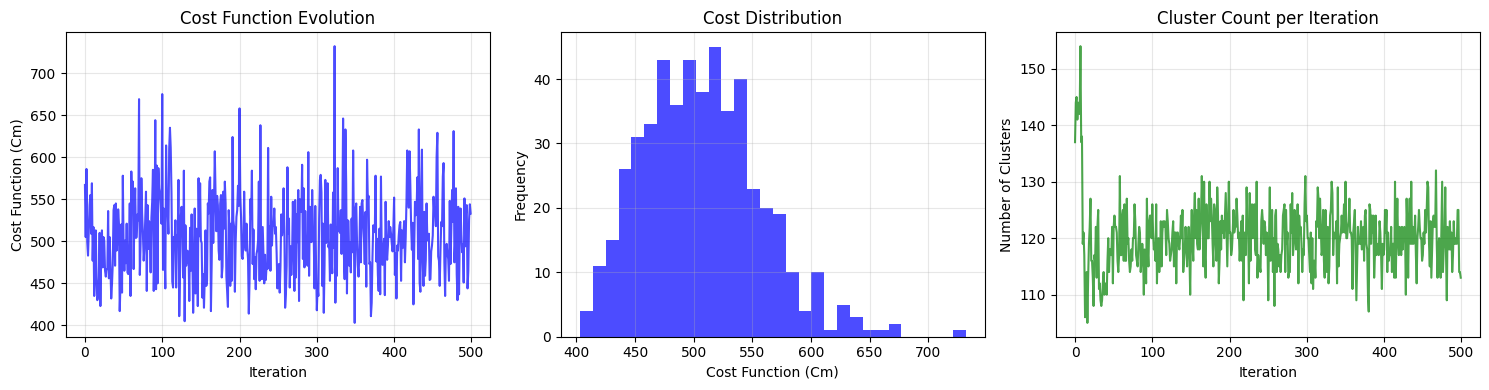

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cost function evolution
axes[0].plot(results['all_Cm'], 'b-', alpha=0.7)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost Function (Cm)')
axes[0].set_title('Cost Function Evolution')
axes[0].grid(True, alpha=0.3)

# Cost distribution (valid solutions < 5000)
cm_valid = [c for c in results['all_Cm'] if c != float('inf') and c < 5000]
if cm_valid:
    axes[1].hist(cm_valid, bins=30, alpha=0.7, color='blue')
    axes[1].set_xlabel('Cost Function (Cm)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Cost Distribution')
    axes[1].grid(True, alpha=0.3)

# Number of clusters
axes[2].plot(results['all_Ntrans'], 'g-', alpha=0.7)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Number of Clusters')
axes[2].set_title('Cluster Count per Iteration')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Lobe Analysis Functions

In [16]:
# ============================================================
# LOBE ANALYSIS FUNCTIONS
# ============================================================

def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    """
    Extract lobe performance metrics from far-field pattern.
    """
    # Find boresight indices
    ele_idx = np.argmin(np.abs(ele - ele0))
    azi_idx = np.argmin(np.abs(azi - azi0))
    
    # Extract cuts
    ele_cut = FF_I_dB[:, azi_idx]  # Elevation cut at azimuth = azi0
    azi_cut = FF_I_dB[ele_idx, :]  # Azimuth cut at elevation = ele0
    
    # Main lobe gain
    main_lobe_gain = G_boresight if G_boresight else np.max(FF_I_dB)
    
    # HPBW (Half-Power Beam Width) - find -3dB points
    def find_hpbw(cut, angles):
        max_idx = np.argmax(cut)
        threshold = cut[max_idx] - 3
        
        # Find left -3dB point
        left_idx = max_idx
        for i in range(max_idx, -1, -1):
            if cut[i] < threshold:
                left_idx = i
                break
        
        # Find right -3dB point
        right_idx = max_idx
        for i in range(max_idx, len(cut)):
            if cut[i] < threshold:
                right_idx = i
                break
        
        return angles[right_idx] - angles[left_idx]
    
    hpbw_ele = find_hpbw(ele_cut, ele)
    hpbw_azi = find_hpbw(azi_cut, azi)
    
    # Side Lobe Level (relative to main lobe)
    def find_sll_relative(cut, angles):
        max_val = np.max(cut)
        max_idx = np.argmax(cut)
        
        # Find peaks excluding main lobe region
        peaks, _ = find_peaks(cut)
        
        # Filter peaks outside main lobe (-3dB region)
        threshold = max_val - 3
        side_peaks = [p for p in peaks if cut[p] < threshold]
        
        if side_peaks:
            max_side = max(cut[p] for p in side_peaks)
            return max_side  # Already relative (normalized pattern)
        return -30  # Default if no side lobes found
    
    sll_ele_relative = find_sll_relative(ele_cut, ele)
    sll_azi_relative = find_sll_relative(azi_cut, azi)
    
    # Count lobes
    peaks_ele, _ = find_peaks(ele_cut, height=-30)
    peaks_azi, _ = find_peaks(azi_cut, height=-30)
    
    return {
        'main_lobe_gain': main_lobe_gain,
        'hpbw_ele': hpbw_ele,
        'hpbw_azi': hpbw_azi,
        'sll_ele_relative': sll_ele_relative,
        'sll_azi_relative': sll_azi_relative,
        'n_lobes_ele': len(peaks_ele),
        'n_lobes_azi': len(peaks_azi),
        'ele_cut': ele_cut,
        'azi_cut': azi_cut,
    }


def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None,
                       title="Lobe Analysis", save_path=None):
    """
    Plot lobe analysis: elevation/azimuth cuts, 2D pattern, metrics table, polar plots.
    """
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi
    
    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Elevation Cut with Lobes
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ele, metrics['ele_cut'], 'b-', linewidth=2, label='Elevation Cut')
    ax1.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax1.axhline(y=metrics['sll_ele_relative'], color='g', linestyle=':', alpha=0.7, 
                label=f'SLL: {metrics["sll_ele_relative"]:.1f}dB')
    ax1.set_xlabel('Elevation [deg]')
    ax1.set_ylabel('Normalized Gain [dB]')
    ax1.set_title(f'Elevation Cut (azi={azi0}°)\nHPBW={metrics["hpbw_ele"]:.1f}°')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([-25, 25])
    
    # 2. Azimuth Cut with Lobes
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(azi, metrics['azi_cut'], 'b-', linewidth=2, label='Azimuth Cut')
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax2.axhline(y=metrics['sll_azi_relative'], color='g', linestyle=':', alpha=0.7,
                label=f'SLL: {metrics["sll_azi_relative"]:.1f}dB')
    ax2.set_xlabel('Azimuth [deg]')
    ax2.set_ylabel('Normalized Gain [dB]')
    ax2.set_title(f'Azimuth Cut (ele={ele0}°)\nHPBW={metrics["hpbw_azi"]:.1f}°')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-25, 25])
    
    # 3. 2D Pattern (contour)
    ax3 = fig.add_subplot(gs[0, 2])
    levels = np.arange(-40, 5, 3)
    contour = ax3.contourf(antenna_array.AZI, antenna_array.ELE, FF_I_dB, 
                           levels=levels, cmap='jet', extend='both')
    plt.colorbar(contour, ax=ax3, label='dB')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='k')
    ax3.set_xlabel('Azimuth [deg]')
    ax3.set_ylabel('Elevation [deg]')
    ax3.set_title('2D Far-Field Pattern')
    
    # 4. Metrics Summary Table
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')
    
    table_data = [
        ['Main Lobe Gain', f'{metrics["main_lobe_gain"]:.2f} dBi'],
        ['HPBW Elevation', f'{metrics["hpbw_ele"]:.1f}°'],
        ['HPBW Azimuth', f'{metrics["hpbw_azi"]:.1f}°'],
        ['SLL Elevation', f'{metrics["sll_ele_relative"]:.1f} dB'],
        ['SLL Azimuth', f'{metrics["sll_azi_relative"]:.1f} dB'],
        ['Lobes (Ele)', f'{metrics["n_lobes_ele"]}'],
        ['Lobes (Azi)', f'{metrics["n_lobes_azi"]}'],
    ]
    
    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      loc='center', cellLoc='center',
                      colWidths=[0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    
    # 5. Polar plot elevation
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    theta_rad = np.deg2rad(ele)
    r = metrics['ele_cut'] + 40  # Shift to positive
    ax5.plot(theta_rad, r, 'b-', linewidth=2)
    ax5.set_theta_zero_location('N')
    ax5.set_title('Elevation Pattern (Polar)', y=1.1)
    
    # 6. Polar plot azimuth
    ax6 = fig.add_subplot(gs[1, 2], projection='polar')
    theta_rad = np.deg2rad(azi)
    r = metrics['azi_cut'] + 40  # Shift to positive
    ax6.plot(theta_rad, r, 'b-', linewidth=2)
    ax6.set_theta_zero_location('N')
    ax6.set_title('Azimuth Pattern (Polar)', y=1.1)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return metrics

print("Lobe analysis functions defined!")

Lobe analysis functions defined!


In [17]:
# ============================================================
# HELPER FUNCTIONS TO EXTRACT FF_I_dB FROM SOLUTIONS
# ============================================================

def rows_to_clusters(selected_rows, optimizer):
    """Convert selected_rows (MC) to Cluster list."""
    return [optimizer._all_clusters_flat[i] for i in np.where(selected_rows == 1)[0]]

def genes_to_clusters(genes, ga_opt):
    """Convert genes (GA) to Cluster list."""
    return [ga_opt.all_subarrays[i] for i in np.where(genes == 1)[0]]

def get_ff_from_mc(solution, antenna_array, mc_optimizer):
    """Get FF_I_dB from a Monte Carlo solution."""
    if 'selected_rows' in solution:
        Cluster = rows_to_clusters(solution['selected_rows'], mc_optimizer)
        if len(Cluster) > 0:
            result = antenna_array.evaluate_clustering(Cluster)
            return result['FF_I_dB'], result['G_boresight']
    return None, None

def get_ff_from_ga(solution, antenna_array, ga_opt):
    """Get FF_I_dB from a Genetic Algorithm solution."""
    if 'genes' in solution:
        Cluster = genes_to_clusters(solution['genes'], ga_opt)
        if len(Cluster) > 0:
            result = antenna_array.evaluate_clustering(Cluster)
            return result['FF_I_dB'], result['G_boresight']
    return None, None

print("Helper functions defined!")

Helper functions defined!


## 16. Lobe Analysis - Monte Carlo Best Solution

LOBE ANALYSIS - MONTE CARLO (Best Solution)


C:\Users\Andrea\AppData\Local\Temp\ipykernel_31444\374056464.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: ../results_png/lobe_analysis_mc.png


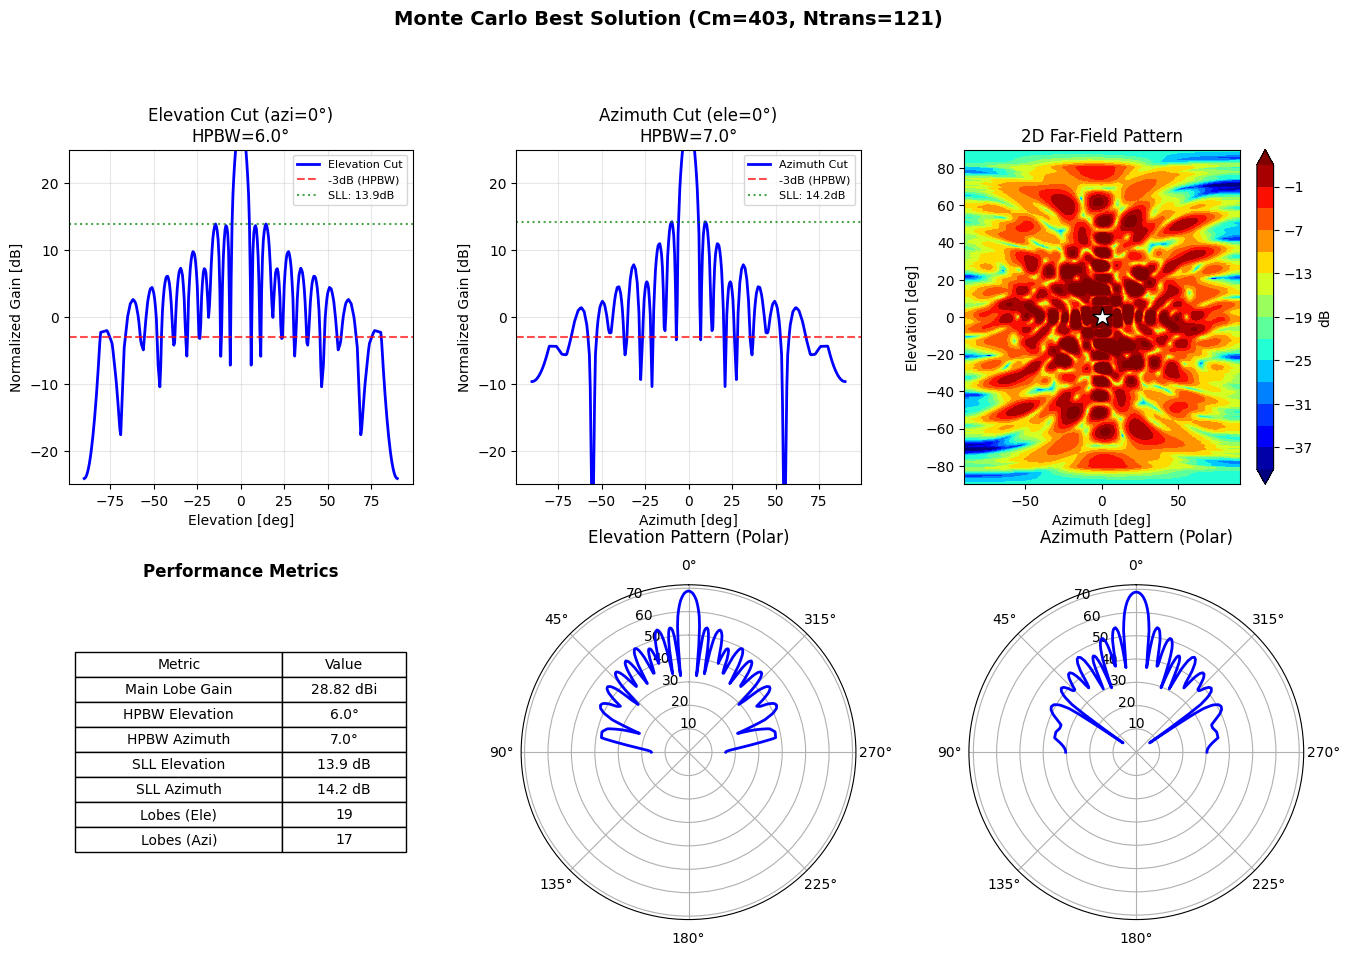

In [18]:
# ============================================================
# LOBE ANALYSIS - MONTE CARLO BEST SOLUTION
# ============================================================

print("="*70)
print("LOBE ANALYSIS - MONTE CARLO (Best Solution)")
print("="*70)

mc_metrics = None
if best and 'selected_rows' in results['simulation'][0]:
    # Get best MC solution
    best_mc_sol = min(results['simulation'], key=lambda x: x['Cm'])
    ff_i_db_mc, g_bore_mc = get_ff_from_mc(best_mc_sol, array, optimizer)
    
    if ff_i_db_mc is not None:
        mc_metrics = plot_lobe_analysis(
            ff_i_db_mc, array,
            G_boresight=g_bore_mc,
            title=f'Monte Carlo Best Solution (Cm={best_mc_sol["Cm"]}, Ntrans={best_mc_sol["Ntrans"]})',
            save_path='../results_png/lobe_analysis_mc.png'
        )
    else:
        print("Could not compute FF_I_dB for MC solution")
else:
    print("No valid MC solution found")

## 17. Lobe Analysis - Genetic Algorithm Best Solution

LOBE ANALYSIS - GENETIC ALGORITHM (Best Solution)


C:\Users\Andrea\AppData\Local\Temp\ipykernel_31444\374056464.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: ../results_png/lobe_analysis_ga.png


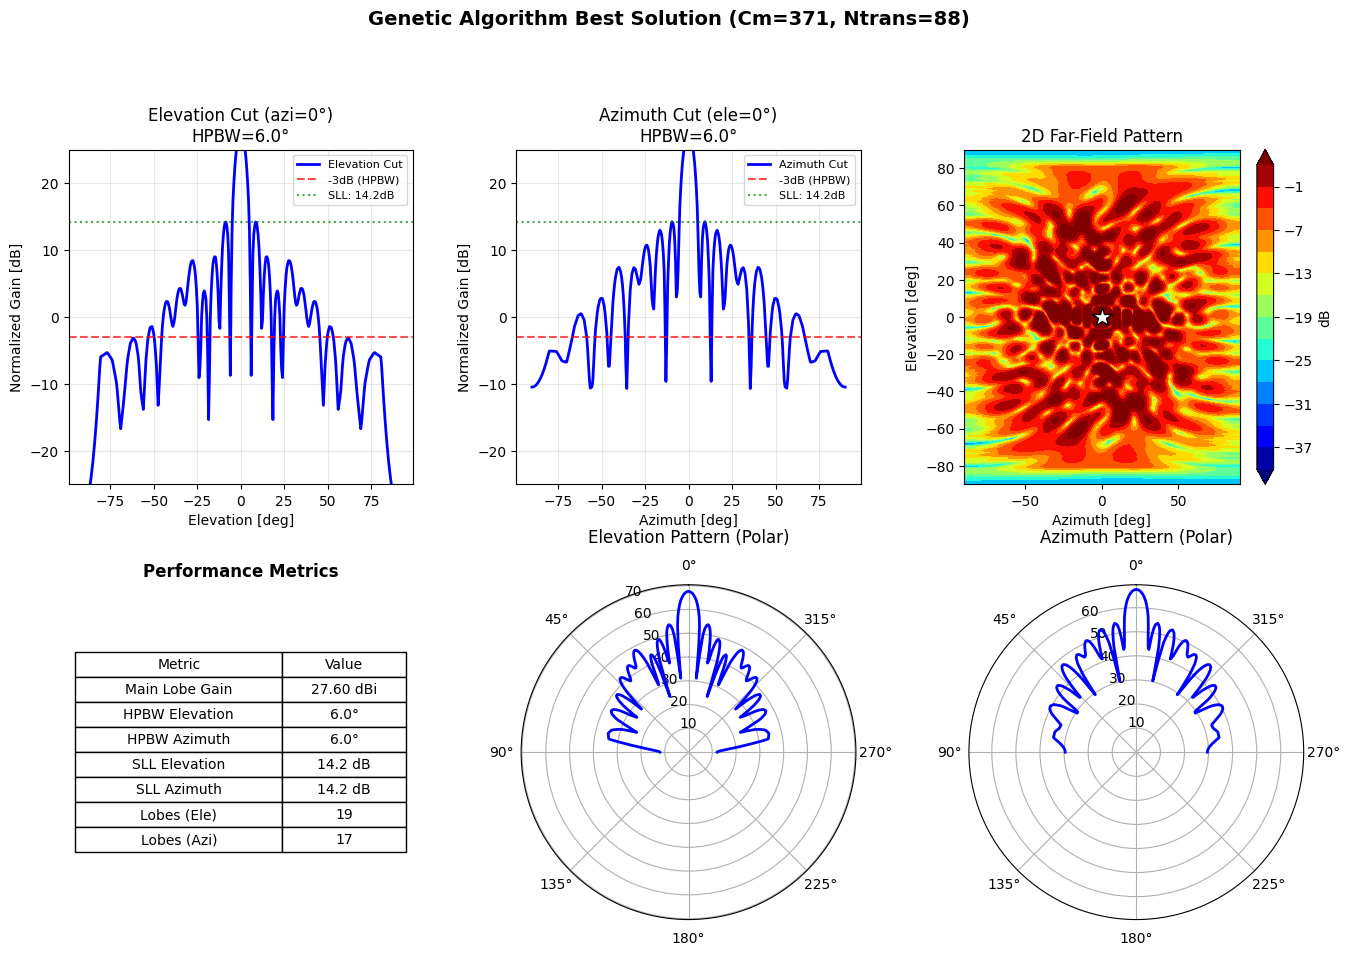

In [19]:
# ============================================================
# LOBE ANALYSIS - GENETIC ALGORITHM BEST SOLUTION
# ============================================================

print("="*70)
print("LOBE ANALYSIS - GENETIC ALGORITHM (Best Solution)")
print("="*70)

ga_metrics = None
if best_ga:
    ff_i_db_ga, g_bore_ga = get_ff_from_ga(best_ga, array, ga_optimizer)
    
    if ff_i_db_ga is not None:
        ga_metrics = plot_lobe_analysis(
            ff_i_db_ga, array,
            G_boresight=g_bore_ga,
            title=f'Genetic Algorithm Best Solution (Cm={best_ga["Cm"]}, Ntrans={best_ga["n_clusters"]})',
            save_path='../results_png/lobe_analysis_ga.png'
        )
    else:
        print("Could not compute FF_I_dB for GA solution")
else:
    print("No valid GA solution found")

## 18. Monte Carlo vs Genetic Algorithm - Comparison Table

In [20]:
# ============================================================
# FINAL COMPARISON TABLE: MONTE CARLO vs GENETIC ALGORITHM
# ============================================================

print()
print("="*80)
print("  FINAL COMPARISON: MONTE CARLO vs GENETIC ALGORITHM")
print("="*80)
print()

# Get best solutions
best_mc = min(results['simulation'], key=lambda x: x['Cm']) if results['simulation'] else None
best_ga_sol = ga_optimizer.best_individual

# Header
print(f"{'Metric':<30} {'Monte Carlo':>20} {'Genetic Algorithm':>20}")
print("-"*80)

# Main metrics
if best_mc and best_ga_sol:
    print(f"{'Cost Function (Cm)':<30} {best_mc['Cm']:>20d} {best_ga_sol['Cm']:>20d}")
    print(f"{'Number of Clusters':<30} {best_mc['Ntrans']:>20d} {best_ga_sol['n_clusters']:>20d}")
    print(f"{'SLL out FoV [dB]':<30} {best_mc['sll_out']:>20.2f} {best_ga_sol['sll_out']:>20.2f}")
    print(f"{'SLL in FoV [dB]':<30} {best_mc['sll_in']:>20.2f} {best_ga_sol['sll_in']:>20.2f}")
    print(f"{'Found at Iteration/Gen':<30} {best_mc['iteration']:>20d} {len(ga_optimizer.history['best_Cm']):>20d}")
    print("-"*80)
    print(f"{'Execution Time [s]':<30} {results['elapsed_time']:>20.2f} {ga_optimizer.elapsed_time:>20.2f}")
    print(f"{'Valid Solutions':<30} {results['n_valid_solutions']:>20d} {'-':>20}")
    print(f"{'Evaluation Budget':<30} {EVAL_BUDGET:>20d} {EVAL_BUDGET:>20d}")
    
    # Lobe metrics if available
    if mc_metrics and ga_metrics:
        print("-"*80)
        print(f"{'HPBW Elevation [°]':<30} {mc_metrics['hpbw_ele']:>20.1f} {ga_metrics['hpbw_ele']:>20.1f}")
        print(f"{'HPBW Azimuth [°]':<30} {mc_metrics['hpbw_azi']:>20.1f} {ga_metrics['hpbw_azi']:>20.1f}")
        print(f"{'SLL Elevation (rel) [dB]':<30} {mc_metrics['sll_ele_relative']:>20.1f} {ga_metrics['sll_ele_relative']:>20.1f}")
        print(f"{'SLL Azimuth (rel) [dB]':<30} {mc_metrics['sll_azi_relative']:>20.1f} {ga_metrics['sll_azi_relative']:>20.1f}")
        print(f"{'Lobes (Elevation)':<30} {mc_metrics['n_lobes_ele']:>20d} {ga_metrics['n_lobes_ele']:>20d}")
        print(f"{'Lobes (Azimuth)':<30} {mc_metrics['n_lobes_azi']:>20d} {ga_metrics['n_lobes_azi']:>20d}")

print("="*80)

# Determine winner
if best_mc and best_ga_sol:
    print()
    if best_mc['Cm'] < best_ga_sol['Cm']:
        winner = "MONTE CARLO"
        diff = best_ga_sol['Cm'] - best_mc['Cm']
    elif best_ga_sol['Cm'] < best_mc['Cm']:
        winner = "GENETIC ALGORITHM"
        diff = best_mc['Cm'] - best_ga_sol['Cm']
    else:
        winner = "TIE"
        diff = 0
    
    print(f"  WINNER (lowest Cm): {winner}")
    if diff > 0:
        print(f"  Advantage: {diff} points better")
    print()
    
    # Hardware reduction
    hw_red_mc = (1 - best_mc['Ntrans'] / array.Nel) * 100
    hw_red_ga = (1 - best_ga_sol['n_clusters'] / array.Nel) * 100
    print(f"  Hardware Reduction MC: {hw_red_mc:.1f}%")
    print(f"  Hardware Reduction GA: {hw_red_ga:.1f}%")

print("="*80)


  FINAL COMPARISON: MONTE CARLO vs GENETIC ALGORITHM

Metric                                  Monte Carlo    Genetic Algorithm
--------------------------------------------------------------------------------
Cost Function (Cm)                              403                  371
Number of Clusters                              121                   88
SLL out FoV [dB]                             -21.53               -20.67
SLL in FoV [dB]                              -14.73               -14.64
Found at Iteration/Gen                          350                    8
--------------------------------------------------------------------------------
Execution Time [s]                           370.57               108.09
Valid Solutions                                 500                    -
Evaluation Budget                               500                  500
--------------------------------------------------------------------------------
HPBW Elevation [°]                           

## 19. Visual Comparison - Side by Side Patterns

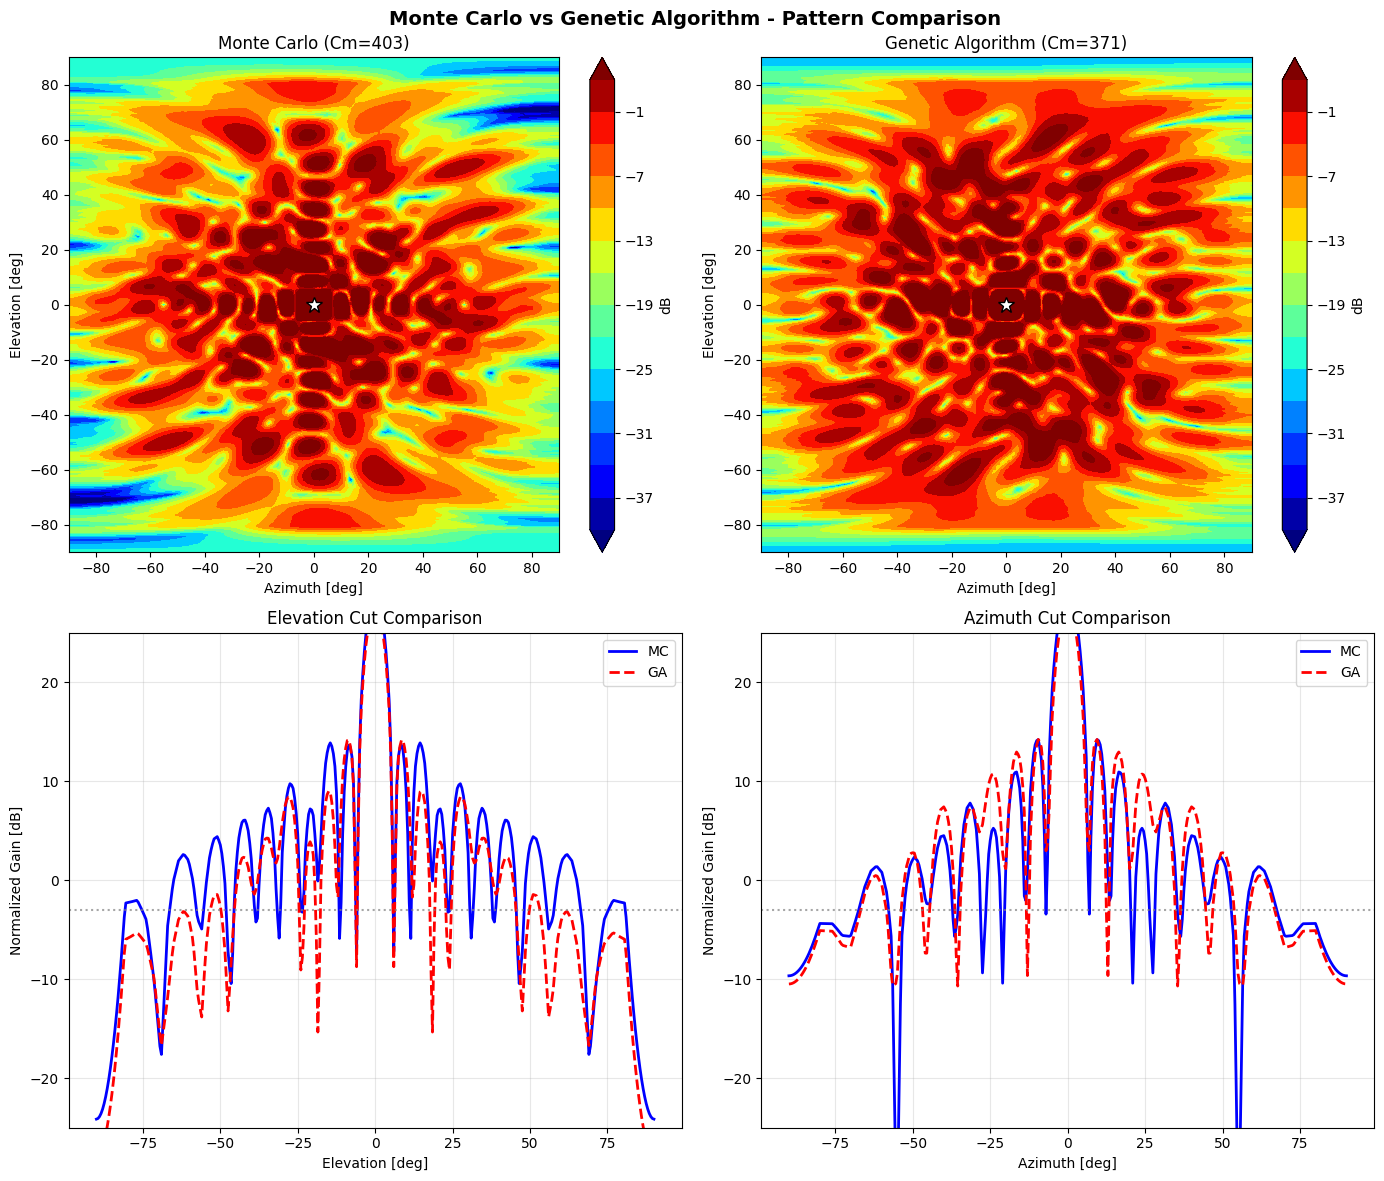

In [21]:
# ============================================================
# VISUAL COMPARISON - SIDE BY SIDE PATTERNS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Get FF patterns
best_mc_sol = min(results['simulation'], key=lambda x: x['Cm']) if results['simulation'] else None
ff_mc, g_mc = get_ff_from_mc(best_mc_sol, array, optimizer) if best_mc_sol else (None, None)
ff_ga, g_ga = get_ff_from_ga(best_ga, array, ga_optimizer) if best_ga else (None, None)

levels = np.arange(-40, 5, 3)

# MC 2D Pattern
if ff_mc is not None:
    c1 = axes[0, 0].contourf(array.AZI, array.ELE, ff_mc, levels=levels, cmap='jet', extend='both')
    plt.colorbar(c1, ax=axes[0, 0], label='dB')
    axes[0, 0].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')
    axes[0, 0].set_xlabel('Azimuth [deg]')
    axes[0, 0].set_ylabel('Elevation [deg]')
    axes[0, 0].set_title(f'Monte Carlo (Cm={best_mc_sol["Cm"]})')

# GA 2D Pattern
if ff_ga is not None:
    c2 = axes[0, 1].contourf(array.AZI, array.ELE, ff_ga, levels=levels, cmap='jet', extend='both')
    plt.colorbar(c2, ax=axes[0, 1], label='dB')
    axes[0, 1].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')
    axes[0, 1].set_xlabel('Azimuth [deg]')
    axes[0, 1].set_ylabel('Elevation [deg]')
    axes[0, 1].set_title(f'Genetic Algorithm (Cm={best_ga["Cm"]})')

# MC Elevation Cut
if mc_metrics:
    axes[1, 0].plot(array.ele, mc_metrics['ele_cut'], 'b-', linewidth=2, label='MC')
if ga_metrics:
    axes[1, 0].plot(array.ele, ga_metrics['ele_cut'], 'r--', linewidth=2, label='GA')
axes[1, 0].axhline(y=-3, color='gray', linestyle=':', alpha=0.7)
axes[1, 0].set_xlabel('Elevation [deg]')
axes[1, 0].set_ylabel('Normalized Gain [dB]')
axes[1, 0].set_title('Elevation Cut Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([-25, 25])

# MC Azimuth Cut
if mc_metrics:
    axes[1, 1].plot(array.azi, mc_metrics['azi_cut'], 'b-', linewidth=2, label='MC')
if ga_metrics:
    axes[1, 1].plot(array.azi, ga_metrics['azi_cut'], 'r--', linewidth=2, label='GA')
axes[1, 1].axhline(y=-3, color='gray', linestyle=':', alpha=0.7)
axes[1, 1].set_xlabel('Azimuth [deg]')
axes[1, 1].set_ylabel('Normalized Gain [dB]')
axes[1, 1].set_title('Azimuth Cut Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([-25, 25])

plt.suptitle('Monte Carlo vs Genetic Algorithm - Pattern Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/mc_vs_ga_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

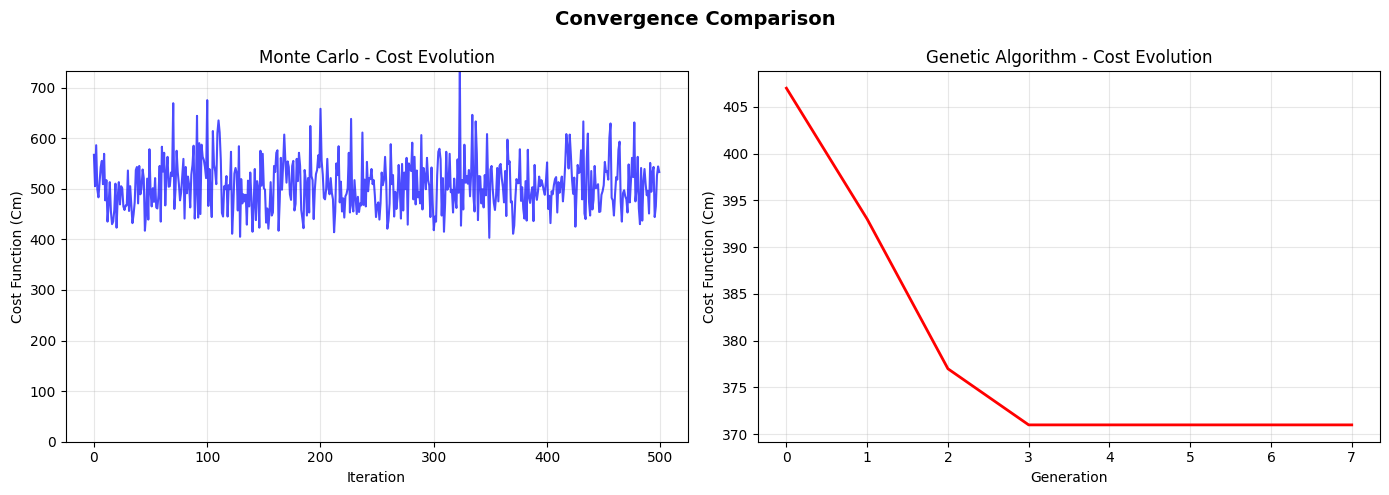

In [22]:
# ============================================================
# CONVERGENCE COMPARISON
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MC Cost Evolution
axes[0].plot(results['all_Cm'], 'b-', alpha=0.7, label='Monte Carlo')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost Function (Cm)')
axes[0].set_title('Monte Carlo - Cost Evolution')
axes[0].grid(True, alpha=0.3)
if results['all_Cm']:
    axes[0].set_ylim([0, min(max(results['all_Cm']), 5000)])

# GA Cost Evolution
axes[1].plot(ga_optimizer.history['best_Cm'], 'r-', linewidth=2, label='Best Cm')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Cost Function (Cm)')
axes[1].set_title('Genetic Algorithm - Cost Evolution')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Convergence Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/convergence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 20. Cluster Layout Visualization

MC Best: 121 clusters
GA Best: 88 clusters


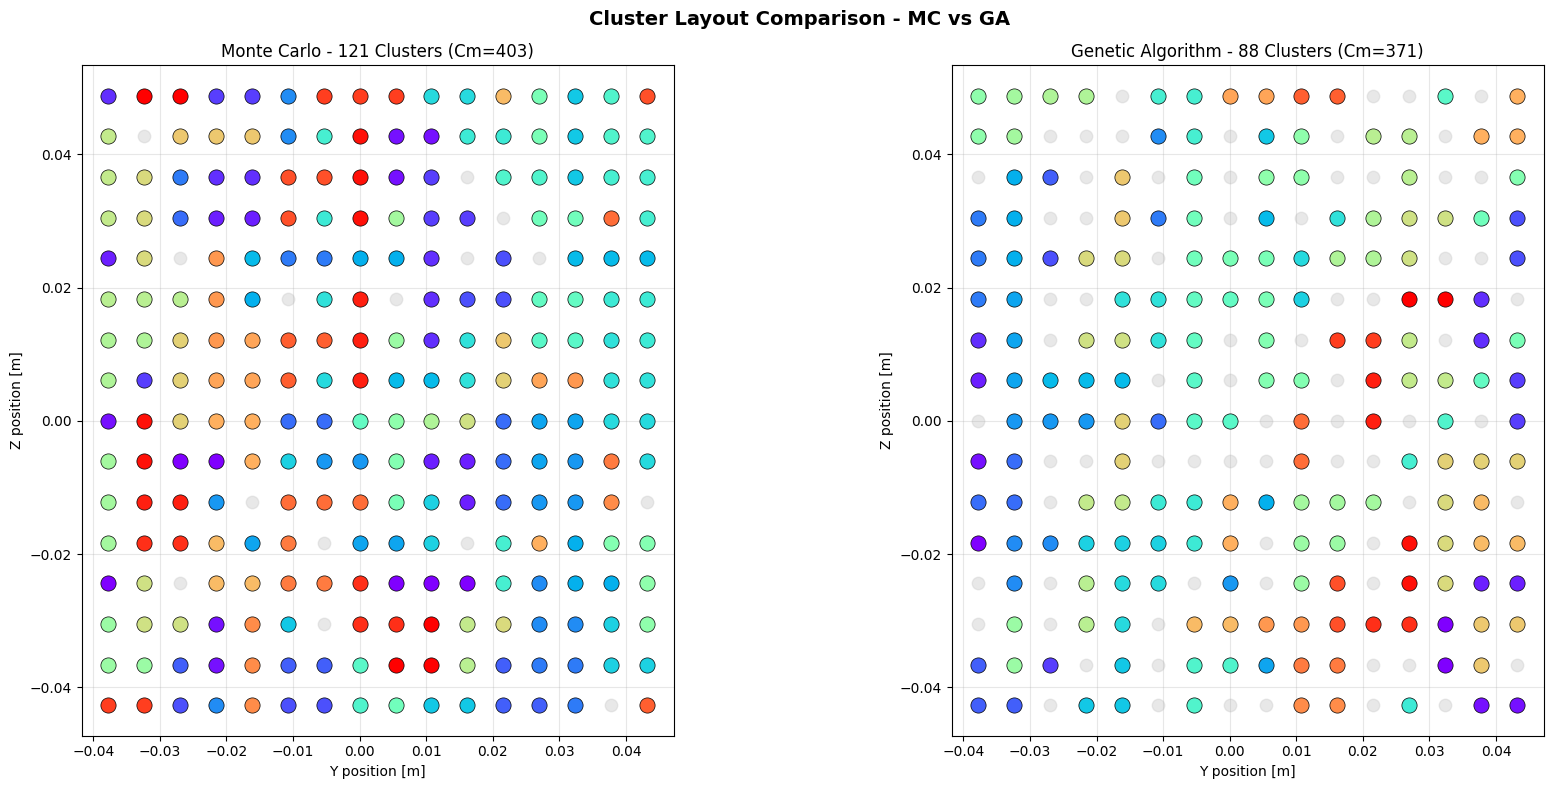


Saved: ../results_png/cluster_layout_comparison.png


In [23]:
# ============================================================
# CLUSTER LAYOUT - MC vs GA
# ============================================================

def plot_cluster_layout(clusters, antenna_array, title="Cluster Layout", ax=None):
    """
    Plot antenna array with clusters colored by group.
    Each cluster gets a unique color.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot all antenna positions in gray (background)
    y_vec = antenna_array.Y.flatten()
    z_vec = antenna_array.Z.flatten()
    ax.scatter(y_vec, z_vec, c='lightgray', s=80, alpha=0.5, label='Unused elements')
    
    # Generate colors for clusters
    n_clusters = len(clusters)
    if n_clusters <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))
    else:
        colors = plt.cm.rainbow(np.linspace(0, 1, min(50, n_clusters)))
    
    # Plot each cluster with its color
    for i, cluster in enumerate(clusters):
        color = colors[i % len(colors)]
        for pos in cluster:
            n_idx, m_idx = pos[0], pos[1]
            # Find position in array
            y_idx = np.where(antenna_array.NN[0, :] == n_idx)[0]
            z_idx = np.where(antenna_array.MM[:, 0] == m_idx)[0]
            if len(y_idx) > 0 and len(z_idx) > 0:
                y = antenna_array.Y[z_idx[0], y_idx[0]]
                z = antenna_array.Z[z_idx[0], y_idx[0]]
                ax.scatter(y, z, c=[color], s=120, edgecolors='black', linewidths=0.5, zorder=10)
    
    ax.set_xlabel('Y position [m]')
    ax.set_ylabel('Z position [m]')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    return ax


# Get clusters from best solutions
best_mc_sol = min(results['simulation'], key=lambda x: x['Cm']) if results['simulation'] else None
mc_clusters = rows_to_clusters(best_mc_sol['selected_rows'], optimizer) if best_mc_sol else []
ga_clusters = genes_to_clusters(best_ga['genes'], ga_optimizer) if best_ga else []

print(f"MC Best: {len(mc_clusters)} clusters")
print(f"GA Best: {len(ga_clusters)} clusters")

# Create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# MC Cluster Layout
plot_cluster_layout(
    mc_clusters, array,
    title=f'Monte Carlo - {len(mc_clusters)} Clusters (Cm={best_mc_sol["Cm"]})',
    ax=axes[0]
)

# GA Cluster Layout
plot_cluster_layout(
    ga_clusters, array,
    title=f'Genetic Algorithm - {len(ga_clusters)} Clusters (Cm={best_ga["Cm"]})',
    ax=axes[1]
)

plt.suptitle('Cluster Layout Comparison - MC vs GA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/cluster_layout_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: ../results_png/cluster_layout_comparison.png")

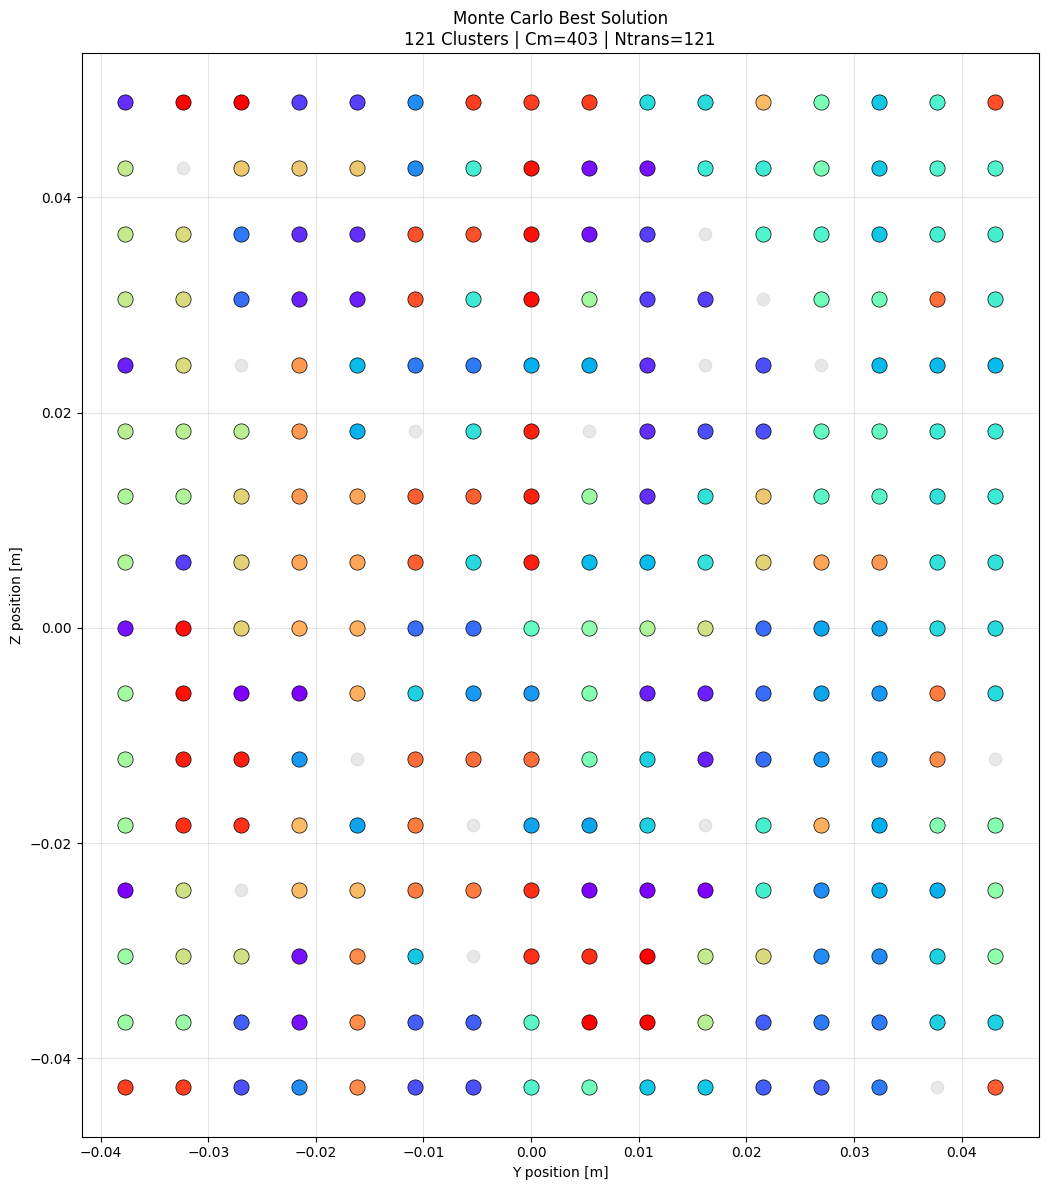

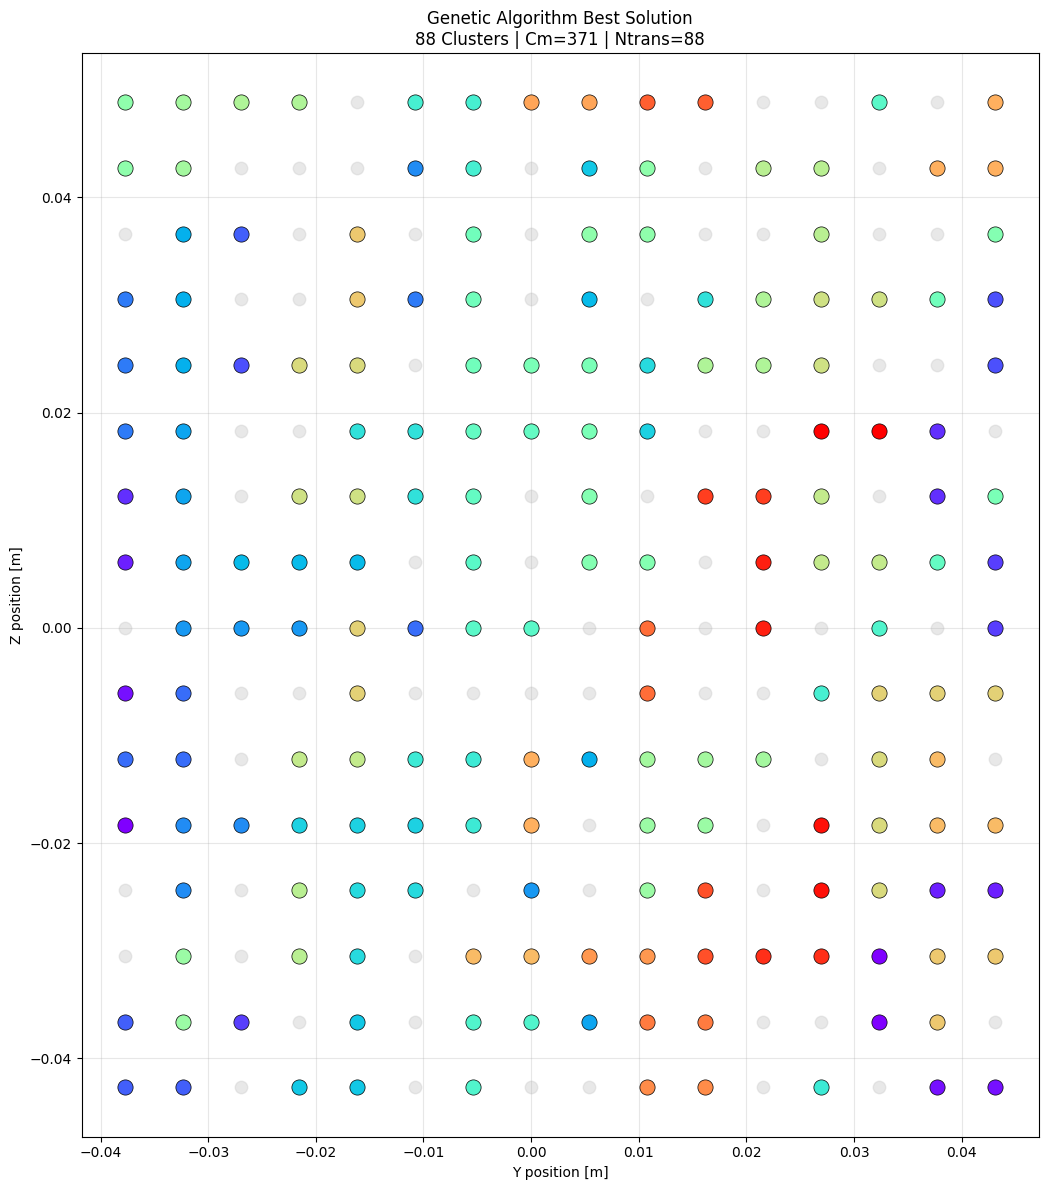

Saved:
  - ../results_png/cluster_layout_mc.png
  - ../results_png/cluster_layout_ga.png


In [24]:
# ============================================================
# INDIVIDUAL CLUSTER LAYOUT PLOTS (larger)
# ============================================================

# MC Cluster Layout - Full size
fig, ax = plt.subplots(figsize=(12, 12))
plot_cluster_layout(
    mc_clusters, array,
    title=f'Monte Carlo Best Solution\n{len(mc_clusters)} Clusters | Cm={best_mc_sol["Cm"]} | Ntrans={best_mc_sol["Ntrans"]}',
    ax=ax
)
plt.tight_layout()
plt.savefig('../results_png/cluster_layout_mc.png', dpi=150, bbox_inches='tight')
plt.show()

# GA Cluster Layout - Full size
fig, ax = plt.subplots(figsize=(12, 12))
plot_cluster_layout(
    ga_clusters, array,
    title=f'Genetic Algorithm Best Solution\n{len(ga_clusters)} Clusters | Cm={best_ga["Cm"]} | Ntrans={best_ga["n_clusters"]}',
    ax=ax
)
plt.tight_layout()
plt.savefig('../results_png/cluster_layout_ga.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved:")
print("  - ../results_png/cluster_layout_mc.png")
print("  - ../results_png/cluster_layout_ga.png")